### Урок 3. Кейс 1. Работа с признаками и селекция#

### -- Автор: Шенк Евгений Станиславович

### Задание 1-2-3.  
1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns
import pandas_profiling
import datetime
import itertools

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import os

import warnings
warnings.filterwarnings("ignore") # отключает предупреждения

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [3]:
data_M = data.resample("M").mean()

In [4]:
data_M.head(3)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714
2002-03-31,28875.256720,2002.0,3.0,16.000000,1.0,75.000000,11.258065,3.193548,11.500000,0.000000,0.000000,0.000000


In [5]:
data_M.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,32108.628796,2009.84000,6.420000,15.645434,2.475000,179.905434,26.140008,2.996992,11.499990,0.027135,0.026964,0.027152
std,3534.668371,4.82606,3.444258,1.084200,1.116066,104.903962,14.634509,0.115045,0.017667,0.022668,0.022522,0.022681
min,26314.458333,2002.00000,1.000000,1.530612,1.000000,16.000000,2.741935,2.530612,11.265306,0.000000,0.000000,0.000000
25%,29193.559812,2006.00000,3.000000,15.500000,1.000000,76.008748,11.702145,2.903226,11.500000,0.000000,0.000000,0.000000
50%,31879.175067,2010.00000,6.000000,16.000000,2.000000,167.500000,24.666667,3.000000,11.500000,0.032258,0.032258,0.032258
75%,34574.729839,2014.00000,9.000000,16.000000,3.000000,259.500000,37.800000,3.095967,11.500000,0.033621,0.033333,0.033621
max,40603.403226,2018.00000,12.000000,16.020188,4.000000,351.000000,51.000000,3.193548,11.515478,0.066759,0.066759,0.066759


In [6]:
data_M.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2002-01-31 to 2018-08-31
Freq: M
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PJME_MW          200 non-null    float64
 1   year             200 non-null    float64
 2   month            200 non-null    float64
 3   dayofmonth       200 non-null    float64
 4   quarter          200 non-null    float64
 5   dayofyear        200 non-null    float64
 6   weekofyear       200 non-null    float64
 7   dayofweek        200 non-null    float64
 8   hour             200 non-null    float64
 9   is_holiday       200 non-null    float64
 10  is_prev_holiday  200 non-null    float64
 11  is_next_holiday  200 non-null    float64
dtypes: float64(12)
memory usage: 20.3 KB


Text(0, 0.5, 'МВт')

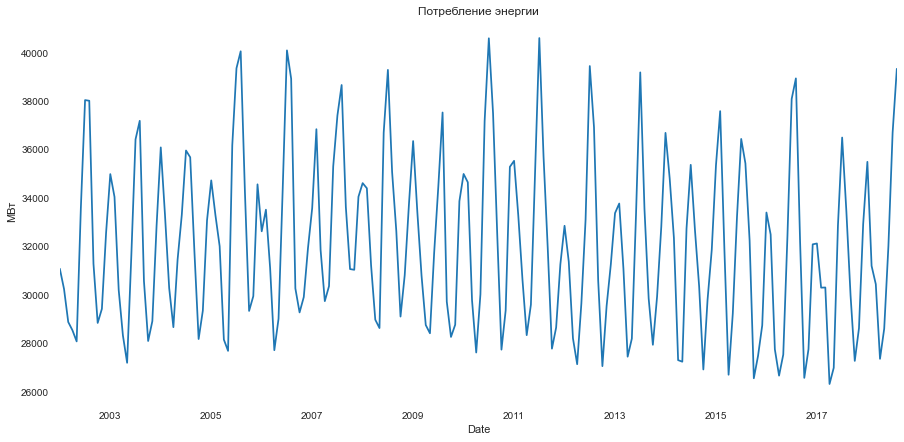

In [7]:
data_M['PJME_MW'].plot(figsize = ( 15, 7 ), title = 'Потребление энергии' )
plt.ylabel ( 'МВт' )

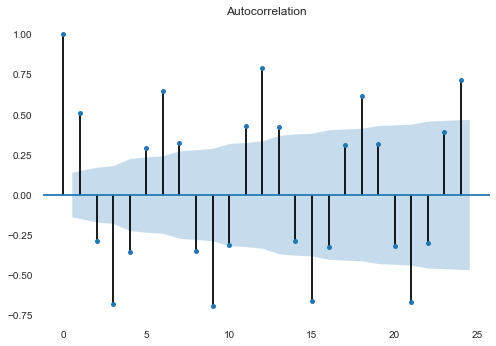

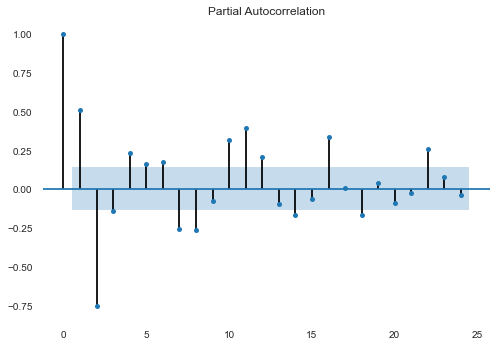

In [8]:
sm.graphics.tsa.plot_acf(data_M['PJME_MW'].values, lags=24)
plt.show()

sm.graphics.tsa.plot_pacf(data_M['PJME_MW'].values, lags=24)
plt.show()

#### По данным графикам видна сезонность, 12 месяцев. Далее подберем параметры для модели SARIMAX

In [9]:
# Определим p, d и q 
q = range(0, 3)
p = range(0, 3)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
# определим комбинации сезонных параметров ps, qs и qs, 
# сезонность это 12 месяцев
qs = range(0, 3)
ps = range(0, 3)
ds = range(0, 2)
season_len = 12
seasonal_pdq = [(x[0], x[1], x[2], season_len) for x in list(itertools.product(ps, ds, qs))] 

In [10]:
"""
N1 = 0     # берем дданные не от начала
N2 = 12    # число точек для теста
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(data_M['PJME_MW'].values[N1:-N2],
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)

            results = model.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
"""

"\nN1 = 0     # берем дданные не от начала\nN2 = 12    # число точек для теста\nfor param in pdq:\n    for param_seasonal in seasonal_pdq:\n        try:\n            model = sm.tsa.statespace.SARIMAX(data_M['PJME_MW'].values[N1:-N2],\n                                              order=param,\n                                              seasonal_order=param_seasonal,\n                                              enforce_stationarity=False,\n                                              enforce_invertibility=False)\n\n            results = model.fit()\n            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))\n        except:\n            continue\n"

#### Возьмем несколько вариантов с хорошим AIC из которых выберем вариант с наименьшими значениями параметров:

In [11]:
# ARIMA(0, 1, 2)x(0, 1, 2, 12)3 - AIC:2613.00753610426
# ARIMA(2, 1, 2)x(1, 1, 2, 12)3 - AIC:2609.3615530851066
# ARIMA(0, 0, 0)x(0, 1, 2, 12)3 - AIC:2695.3223171841873
# ARIMA(0, 0, 1)x(0, 1, 2, 12)3 - AIC:2653.7508364106643
order_opt = [0, 0, 0]
seasonal_order_opt = [0, 1, 2, 12]

In [12]:
#для построения модели используем все данные, кроме 12 последних месяцев (это будет тестовый набор)
N1 = 0     # берем дданные не от начала
N2 = 12    # число точек для теста
nforecast = N2+24

model = sm.tsa.statespace.SARIMAX(data_M['PJME_MW'].values[N1:-N2],
                                  order=order_opt,
                                  seasonal_order=seasonal_order_opt,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results_opt = model.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 2695.3223171841873


In [13]:
results_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ma.S.L12,-0.6631,0.083,-8.027,0.000,-0.825,-0.501
ma.S.L24,0.2141,0.046,4.640,0.000,0.124,0.305
sigma2,3.536e+06,4.37e+05,8.100,0.000,2.68e+06,4.39e+06


#### По данной таблице видно, что все выбраные нами параметры важны

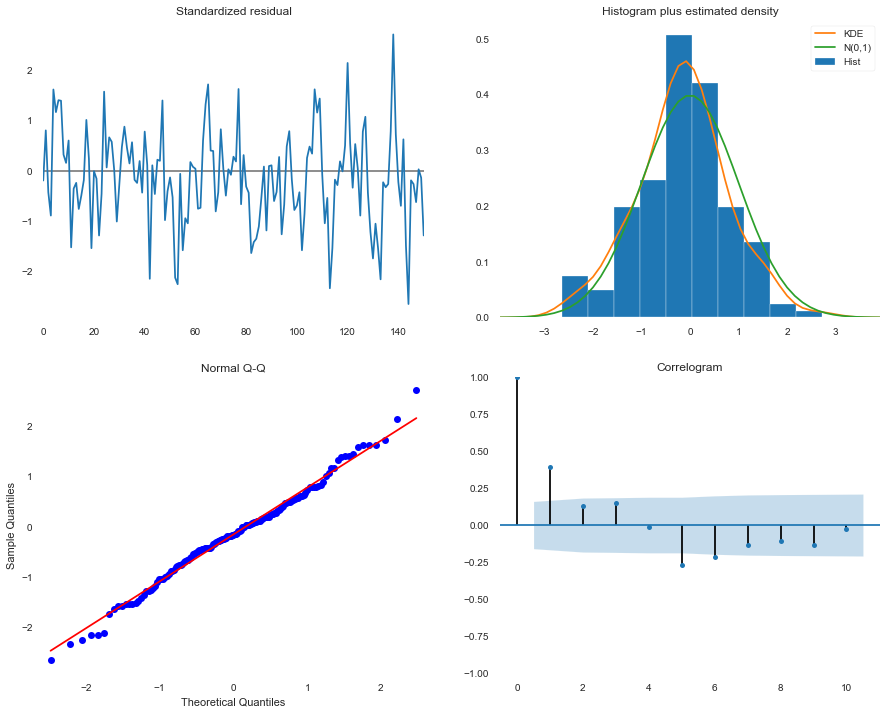

In [15]:
results_opt.plot_diagnostics(figsize=(15, 12))
plt.show()

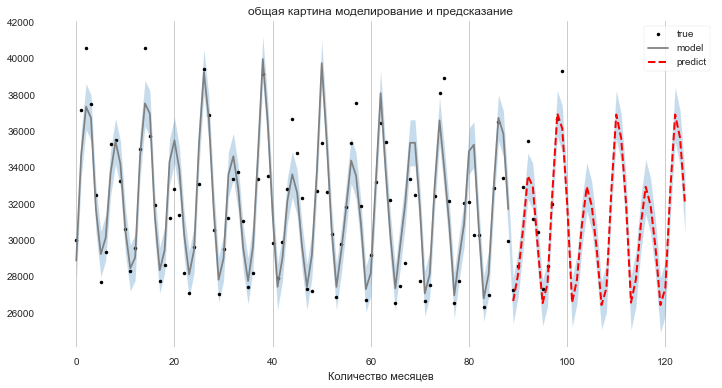

In [16]:
N3=100  # отступ данных для отображения  модели (для улучшения визуальных качеств рисунка - берем из интервала [0-500])
nforecast = N2+24  # общее число точек для предсказания (N2 - тестовых точек + точки для чистого предсказания)
predict_ = results_opt.get_prediction(end=results_opt.nobs + nforecast)  # делаем предсказание

# отображаем
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_M['PJME_MW'].values[N3+N1:], 'k.',label='true')

# 
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], 'gray',label = 'model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание', xlabel='Количество месяцев');

In [17]:
#Для сравнения построим надельный вариант:

In [18]:
data_W = data.resample("W").mean()

In [19]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения
N1 =300   # берем дданные не от начала - так быстрее работает
N2 =12  # число точек для теста
nforecast = N2+30

mod = sm.tsa.statespace.SARIMAX(data_W['PJME_MW'].values[N1:-N2],order=[0,0,1],
                                seasonal_order=[0,1,2,52] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()

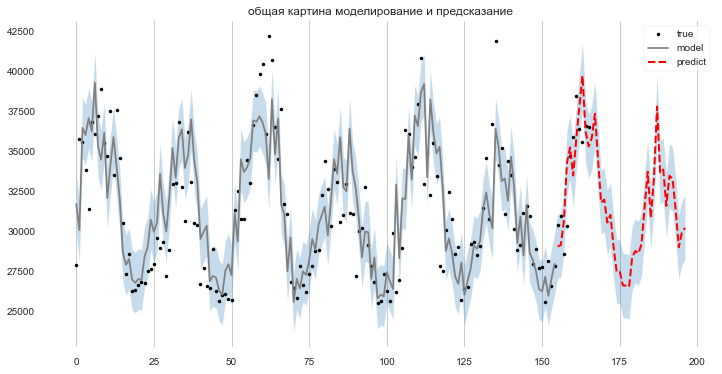

In [20]:
N3=400  # отступ данных для отображения  модели (для улучшения визуальных качеств рисунка - берем из интервала [0-500])
nforecast = N2+30  # общее число точек для предсказания (N2 - тестовых точек + точки для чистого предсказания)
predict_ = results_opt.get_prediction(end=results_opt.nobs + nforecast)  # делаем предсказание

# отображаем
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_W['PJME_MW'].values[N3+N1:], 'k.',label='true')

# 
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], 'gray',label = 'model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание');

### По сравнению с недельной моделью на месячной более видна сезонность, график более гладкий.

### Задание 4-5.  
4. Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)

5. Оцените результат моделирования

In [21]:
data_brent = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])

In [22]:
data_brent_W = data_brent.resample("W").mean()

In [23]:
data_brent_W.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2010-09-05 to 2019-09-01
Freq: W-SUN
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         469 non-null    float64
 1   year             469 non-null    float64
 2   month            469 non-null    float64
 3   dayofmonth       469 non-null    float64
 4   quarter          469 non-null    float64
 5   dayofyear        469 non-null    float64
 6   weekofyear       469 non-null    float64
 7   dayofweek        469 non-null    float64
 8   is_holiday       469 non-null    float64
 9   is_prev_holiday  469 non-null    float64
 10  is_next_holiday  469 non-null    float64
dtypes: float64(11)
memory usage: 44.1 KB


Text(0, 0.5, '$')

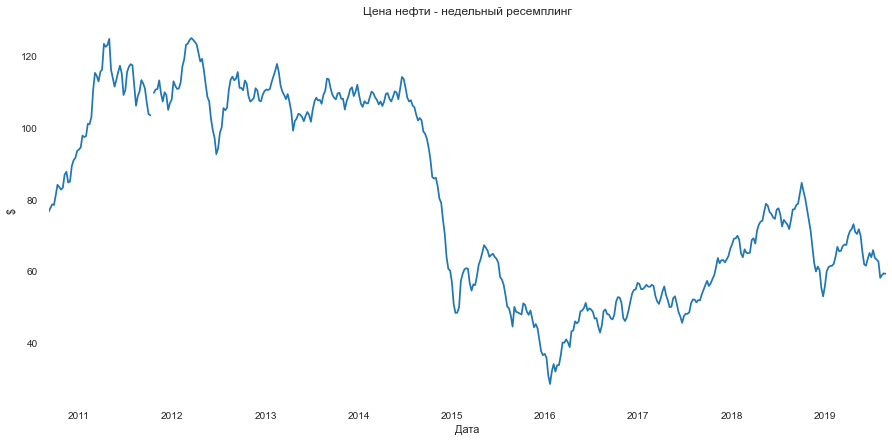

In [24]:
data_brent_W['Значение'].plot(figsize = ( 15, 7 ), title = 'Цена нефти - недельный ресемплинг' )
plt.ylabel ( '$' )

### Разрыв на графике возникает из-за 10 дневного пропуска данных.

In [25]:
data_brent_W.loc[(data_brent_W.index > '2011-10-01') & (data_brent_W.index < '2011-10-31')]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2011-10-02,103.878333,2011.0,9.166667,23.666667,3.166667,271.666667,39.0,2.666667,0.0,0.000000,0.0
2011-10-09,103.476667,2011.0,10.000000,5.666667,4.000000,278.666667,40.0,2.666667,0.0,0.166667,0.0
2011-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-23,109.756667,2011.0,10.000000,21.333333,4.000000,294.333333,42.0,4.333333,0.0,0.000000,0.0
2011-10-30,110.680000,2011.0,10.000000,26.666667,4.000000,299.666667,43.0,2.666667,0.0,0.000000,0.0


In [26]:
data_brent.loc[(data_brent.index > '2011-10-07') & (data_brent.index < '2011-10-23')]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2011-10-09,104.13,2011,10,9,4,282,40,6,0,1,0
2011-10-20,109.93,2011,10,20,4,293,42,3,0,0,0
2011-10-21,109.79,2011,10,21,4,294,42,4,0,0,0


### Заполним пропуск:

In [27]:
data_brent_W = data_brent.resample("W").mean().interpolate(method='linear')

In [28]:
data_brent_W.loc[(data_brent_W.index > '2011-10-01') & (data_brent_W.index < '2011-10-31')]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2011-10-02,103.878333,2011.0,9.166667,23.666667,3.166667,271.666667,39.0,2.666667,0.0,0.000000,0.0
2011-10-09,103.476667,2011.0,10.000000,5.666667,4.000000,278.666667,40.0,2.666667,0.0,0.166667,0.0
2011-10-16,106.616667,2011.0,10.000000,13.500000,4.000000,286.500000,41.0,3.500000,0.0,0.083333,0.0
2011-10-23,109.756667,2011.0,10.000000,21.333333,4.000000,294.333333,42.0,4.333333,0.0,0.000000,0.0
2011-10-30,110.680000,2011.0,10.000000,26.666667,4.000000,299.666667,43.0,2.666667,0.0,0.000000,0.0


Text(0, 0.5, '$')

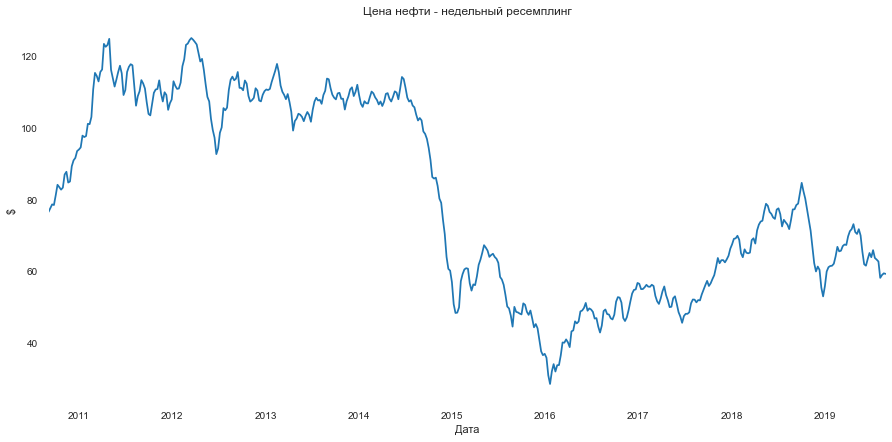

In [29]:
data_brent_W['Значение'].plot(figsize = ( 15, 7 ), title = 'Цена нефти - недельный ресемплинг' )
plt.ylabel ( '$' )

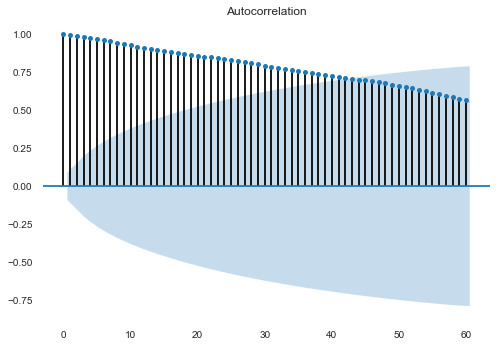

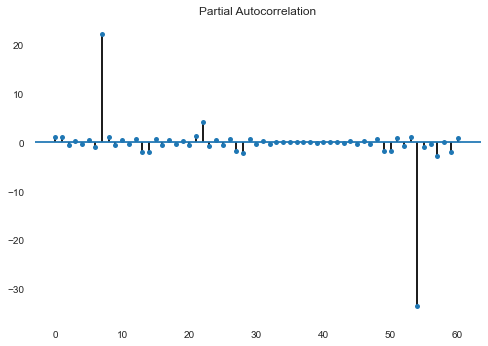

In [30]:
sm.graphics.tsa.plot_acf(data_brent_W['Значение'].values, lags=60)
plt.show()

sm.graphics.tsa.plot_pacf(data_brent_W['Значение'].values, lags=60)
plt.show()

### AutoCorr И Partial AutoCorr для первых разностей:

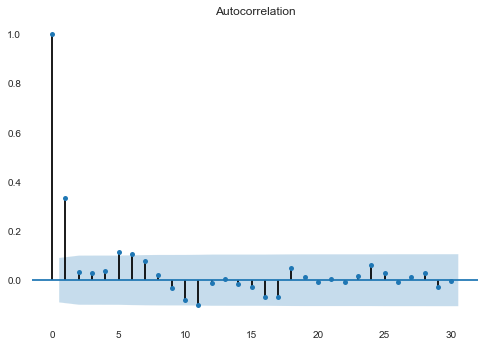

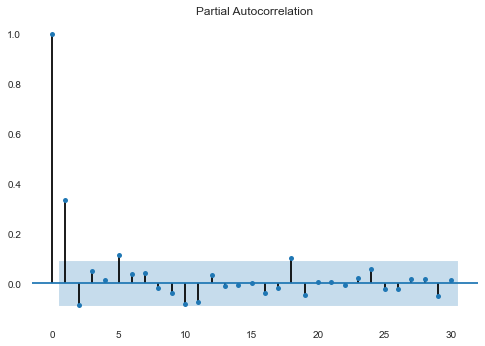

In [31]:
brent_dif = data_brent_W['Значение'].diff(1)

sm.graphics.tsa.plot_acf(brent_dif[1:], lags=30)
plt.show()

sm.graphics.tsa.plot_pacf(brent_dif[1:], lags=30)
plt.show()

Получается для дальнейшего подбора параметров разумно взять d=1, а q и p возьмен небольшие (от 0 до 5)

In [32]:
# Определим p, d и q 
q = range(0, 3)
p = range(0, 3)
d = [1]
pdq = list(itertools.product(p, d, q))
param_seasonal = [0, 0, 0, 0] # нет сезона

In [33]:
N1 = 0     # берем дданные не от начала
N2 = 12    # число точек для теста
for param in pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(data_brent_W['Значение'].values[N1:-N2],
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results = model.fit()
        print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
        continue

ARIMA(0, 1, 0)x[0, 0, 0, 0]3 - AIC:2038.628501241607
ARIMA(0, 1, 1)x[0, 0, 0, 0]3 - AIC:1975.5084990901373
ARIMA(0, 1, 2)x[0, 0, 0, 0]3 - AIC:1973.806801242458
ARIMA(1, 1, 0)x[0, 0, 0, 0]3 - AIC:1983.5836380508433
ARIMA(1, 1, 1)x[0, 0, 0, 0]3 - AIC:1977.2785391396635
ARIMA(1, 1, 2)x[0, 0, 0, 0]3 - AIC:1973.8876011029115
ARIMA(2, 1, 0)x[0, 0, 0, 0]3 - AIC:1978.3058304368344
ARIMA(2, 1, 1)x[0, 0, 0, 0]3 - AIC:1978.8919996497048
ARIMA(2, 1, 2)x[0, 0, 0, 0]3 - AIC:1975.60177546656


In [34]:
# ARIMA(0, 1, 1)x[0, 0, 0, 0]3 - AIC:1975.5084990901373
param = [0, 1, 1]
param_seasonal = [0, 0, 0, 0] # нет сезона
model = sm.tsa.statespace.SARIMAX(data_brent_W['Значение'].values[N1:-N2],
                                  order=param,
                                  seasonal_order=param_seasonal,
                                  trend='ct',
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
result_brent_W = model.fit()
print(result_brent_W.summary().tables[0], result_brent_W.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  458
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -985.530
Date:                Sun, 14 Jun 2020   AIC                           1979.060
Time:                        20:04:31   BIC                           1995.541
Sample:                             0   HQIC                          1985.553
                                - 458                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0833      0.237      0.352      0.7

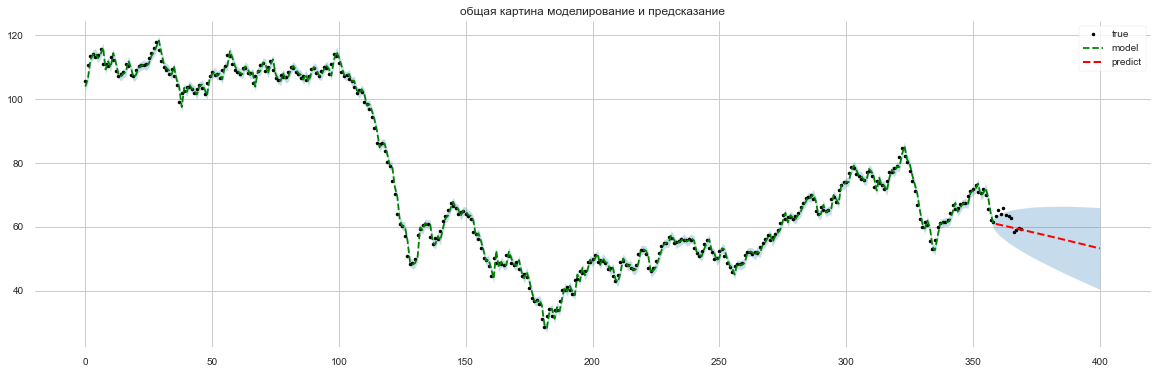

In [35]:
N1 = 0
N2 = 12 
N3 = 100  # отступ данных для отображения  модели (для улучшения визуальных качеств рисунка - берем из интервала [0-500])
nforecast = N2+30  # общее число точек для предсказания (N2 - тестовых точек + точки для чистого предсказания)
predict_ = result_brent_W.get_prediction(end = result_brent_W.nobs + nforecast)   
# получаем результаты работы модели по всей выборке

# отображаем результаты
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(data_brent_W['Значение'].values[N3:], 'k.',label='true')
#plt.ylim([40,100])
plt.grid()
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], '--g',label='model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2,label = 'predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()

ax.set(title='общая картина моделирование и предсказание');

In [36]:
adf_test_brent = sm.tsa.stattools.adfuller(result_brent_W.resid)
adf_test_brent[1]

0.0

### Можно  прогнозировать значения модели в диапазоне дисперсии остатков.

### Задание 6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.

Модели регулярных рядов (Потребление энергии) лучше предсказываются, чем нерегулярные ряды (Brent) с помощью ARIMA